### *import

In [1]:
import pandas as pd
import numpy as np
import json
import os
import tqdm
import time
from datetime import timedelta
import pickle as pkl
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn import metrics
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

UNK, PAD, SEP = '<UNK>', '<PAD>', '<SEP>'  # 未知字，padding符号
torch.cuda.set_device(0)

In [2]:
def join(path):
    '''
    hide the home path
    '''
    home_path = os.path.expanduser('~')
    path = os.path.join(home_path, path)
    return path

## data_process

In [3]:
data_dir = join(r'data/snli_1.0')
data_path = os.path.join(data_dir, 'snli_1.0_train.jsonl')
df = pd.read_json(data_path, lines=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550152 entries, 0 to 550151
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   annotator_labels        550152 non-null  object
 1   captionID               550152 non-null  object
 2   gold_label              550152 non-null  object
 3   pairID                  550152 non-null  object
 4   sentence1               550152 non-null  object
 5   sentence1_binary_parse  550152 non-null  object
 6   sentence1_parse         550152 non-null  object
 7   sentence2               550152 non-null  object
 8   sentence2_binary_parse  550152 non-null  object
 9   sentence2_parse         550152 non-null  object
dtypes: object(10)
memory usage: 42.0+ MB


In [31]:
df['gold_label'].value_counts()
df = df.loc[df['gold_label'] != '-']
df['gold_label'].value_counts()

entailment       183416
contradiction    183187
neutral          182764
-                   785
Name: gold_label, dtype: int64

entailment       183416
contradiction    183187
neutral          182764
Name: gold_label, dtype: int64

In [39]:
df['sen1_len'] = df['sentence1'].apply(lambda x: len(x.split(' ')))
df['sen2_len'] = df['sentence2'].apply(lambda x: len(x.split(' ')))

<AxesSubplot:xlabel='sen1_len', ylabel='count'>

([], [])

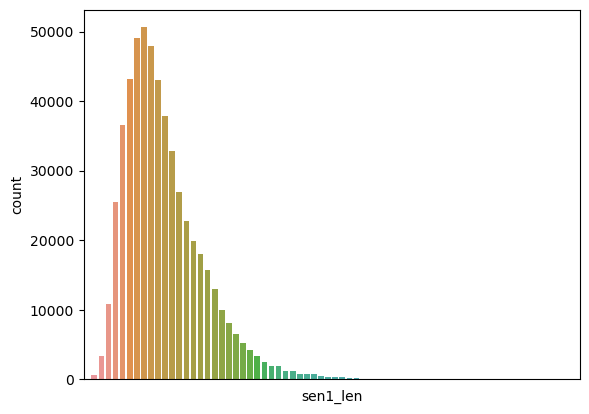

<AxesSubplot:xlabel='sen2_len', ylabel='count'>

([], [])

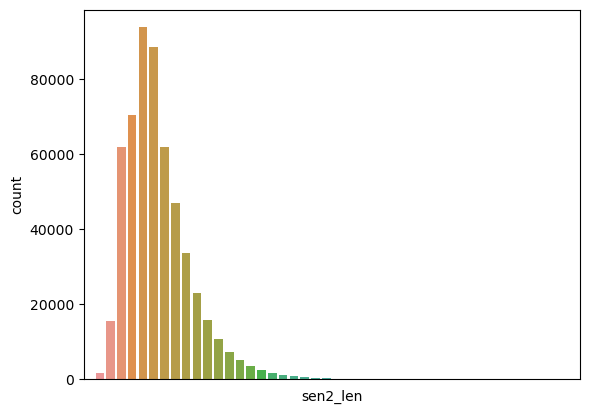

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.countplot(x='sen1_len', data=df)
plt.xticks([])
plt.show()

sns.countplot(x='sen2_len', data=df)
plt.xticks([])
plt.show()

<AxesSubplot:xlabel='sen1_len', ylabel='Count'>

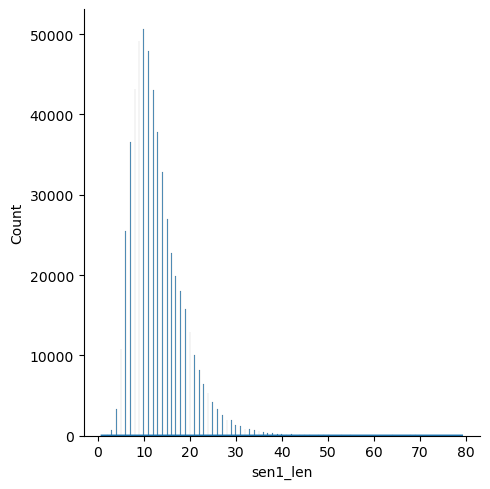

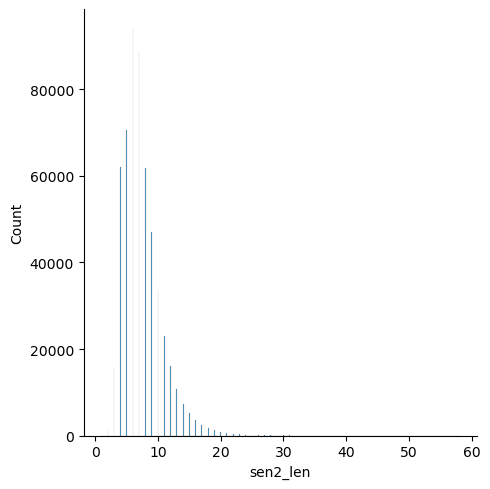

In [41]:
sns.displot(df['sen1_len']) # plt.hist and sns.kdeplot
sns.kdeplot(df['sen1_len'])
plt.show()

sns.displot(df['sen2_len']) # plt.hist and sns.kdeplot
plt.show()

### build label_map

In [237]:
labels = df['gold_label'].unique().tolist()
label_map = dict.fromkeys(labels, None)
label_map
for i, label in enumerate(labels):
    label_map.update({label:i})
label_map
pkl.dump(label_map, open(os.path.join(data_dir, 'label_map.pkl'), 'wb'))

{'neutral': None, 'contradiction': None, 'entailment': None}

{'neutral': 0, 'contradiction': 1, 'entailment': 2}

### glove process

In [210]:
glove_path = join(r'pretrained_models/glove/standford/glove.6B.200d.txt')
with open(glove_path, 'r', encoding='utf-8') as f:
    vocab_map = {}
    data = list()
    for i,line in enumerate(f.readlines()):
        w2vlist = line.split()
        word, vector = w2vlist[0], w2vlist[1:]
        vocab_map[word] = i
        data.append(vector)
    data.append([0]*len(data[0]))
    data.append([0]*len(data[0]))
    data.append([0]*len(data[0]))
    vocab_map.update({UNK: len(vocab_map), SEP:len(vocab_map)+1, PAD: len(vocab_map) + 2})
    data = np.array(data, float)
pkl.dump(vocab_map, open(join(r'pretrained_models/glove/standford/vocab_map.pkl'), 'wb'))
pkl.dump(data, open(join(r'pretrained_models/glove/standford/glove.6B.200d.pkl'), 'wb'))

## utils

### *get_time_dif

In [3]:
def get_time_dif(start_time):
    end_time = time.time()
    time_dif = end_time - start_time
    return timedelta(seconds=int(round(time_dif)))

### *Config

In [18]:
class Config(object):
    def __init__(self, embed_path=None, vocab_path=None):
        
        # pararms for dataset
        self.train_path = join(r'data/snli_1.0/snli_1.0_train.jsonl')
        self.dev_path = join(r'data/snli_1.0/snli_1.0_dev.jsonl')
        self.test_path = join(r'data/snli_1.0/snli_1.0_test.jsonl')
        self.save_path = './ouput/saved_dict.ckpt'
        if not os.path.exists(os.path.dirname(self.save_path)):
            os.makedirs(os.path.dirname(self.save_path))
        
        # for self-build dataset
#         self.train_set_path = r'./data_set/train.pkl'
#         self.dev_set_path = r'./data_set/dev.pkl'
#         self.test_set_path = r'./data_set/test.pkl'

        self.vocab_map = pkl.load(open(vocab_path, 'rb')) if vocab_path else pkl.load(open(join(r'pretrained_models/glove/standford/vocab_map.pkl'), 'rb'))
        self.n_vocab = len(self.vocab_map)
        self.label_map = pkl.load(open(join(r'data/snli_1.0/label_map.pkl'), 'rb'))
        self.label_num = len(self.label_map)
        
        # params for train
        self.pad_size_p = 64
        self.pad_size_h = 32
        self.batch_size = 32
        self.epoch = 20
        self.learning_rate = 1e-4
        self.drop_out = 0.3
        self.log_step = 1000
        self.require_improvement = self.log_step*10
        self.early_stop = False
        
        # params for embedding
        self.embedding_pretrained = torch.FloatTensor(pkl.load(open(embed_path, 'rb'))) if embed_path is not None else None
        self.embedding_size = self.embedding_pretrained.size(1) if self.embedding_pretrained is not None else 600
        
        # params for rnn_like models
        self.hidden_size = 600
        self.num_layer = 2
        self.bidirectional = True
        
        # param for MLP
        self.linear_size = 600
        
        # params for cnn model
        self.num_channel = 256
        self.kernel_sizes = (3, 4, 5)
        
        # device
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
config = Config()

In [6]:
config.n_vocab
config.label_map
config.embedding_size

400003

{'neutral': 0, 'contradiction': 1, 'entailment': 2}

600

### *Dataset Iterater

In [7]:
def SNLItokenizer(sentence, pad_size):
    tokenizer = lambda x: x.split() # word_level tokenzier
    def pad_and_trunc(tokens):
        if len(tokens) < pad_size:
            tokens.extend([PAD] * (pad_size - len(tokens)))
        else:
            tokens = tokens[:pad_size]
        return tokens
    tokens = tokenizer(sentence)
    tokens = pad_and_trunc(tokens)
    return tokens
    
class SNLIDataset(Dataset):
    
    def __init__(self, hypothesis, premise, labels, config):
        self.hypothesis = hypothesis
        self.premise = premise
        self.labels = labels
        self.device = config.device
        self.vocab_map = config.vocab_map
        self.label_map = config.label_map

    def __getitem__(self, index):
        # padding and truncation
        tokens_p = SNLItokenizer(self.premise[index], config.pad_size_p)
        tokens_h = SNLItokenizer(self.hypothesis[index], config.pad_size_h)
        ind_p = [self.vocab_map.get(token, self.vocab_map.get(UNK)) for token in tokens_p]
        ind_h = [self.vocab_map.get(token, self.vocab_map.get(UNK)) for token in tokens_h]
        p = torch.LongTensor(ind_p).to(self.device)
        h = torch.LongTensor(ind_h).to(self.device)
        y = torch.LongTensor([self.label_map.get(self.labels[index])]).to(self.device)
        return (p, h), y

    def __len__(self):
        return len(self.labels)

def build_dataset(config):
    def load_dataset(path):
        df = pd.read_json(path, lines=True)
        df.drop(df.loc[df['gold_label']=='-'].index, inplace=True)
        data = SNLIDataset(df['sentence1'].tolist(), df['sentence2'].tolist(), df['gold_label'].tolist(), config)
        print("{0} loaded succcess, {1} in total.".format(os.path.split(path)[-1], len(data)))
        return data
    start_time = time.time()
    print('loading data...')
    train_set = load_dataset(config.train_path)
    dev_set = load_dataset(config.dev_path)
    test_set = load_dataset(config.test_path)
    time_used = get_time_dif(start_time)
    print('Time used:', time_used)
    return train_set, dev_set, test_set
    
# tensor_dataloader = DataLoader(tensor_dataset,     # 封装的对象
#                                batch_size = 2,     # 输出的batch size
#                                shuffle = True,     # 随机输出
#                                num_workers = 0)    # 只有1个进程

In [12]:
config = Config()
train_set, dev_set, test_set = build_dataset(config)

loading data...
snli_1.0_train.jsonl loaded succcess, 549367 in total.
snli_1.0_dev.jsonl loaded succcess, 9842 in total.
snli_1.0_test.jsonl loaded succcess, 9824 in total.
Time used: 0:00:10


In [13]:
train_iter = DataLoader(train_set, batch_size = config.batch_size, shuffle = True, num_workers = 0)    # 只有1个进程
dev_iter = DataLoader(dev_set, batch_size = config.batch_size, shuffle = True, num_workers = 0)    # 只有1个进程
test_iter = DataLoader(test_set, batch_size = config.batch_size, shuffle = True, num_workers = 0)    # 只有1个进程

In [34]:
first = next(iter(test_iter))
first

## model

### LSTM with Attention

In [ ]:
class ESIM(nn.Module):
    self.__init__(self):
        super.__init__(ESIM)

### LSTM with word by word Attention

###  * ESIM

reference: <br>
https://github.com/coetaur0/ESIM <br>
https://github.com/MrXJC/ESIM<br>
https://github.com/Alic-yuan/nlp-beginner-finish <br>
查看高清大图修改percentage of width
<img src="esim.png" width="30%"> 

In [8]:
class ESIM(nn.Module):
    def __init__(self, config):
        super(ESIM, self).__init__()
        
        # 1. embedding layer
        if config.embedding_pretrained is not None:
            self.embedding = nn.Embedding.from_pretrained(config.embedding_pretrained, freeze=False, padding_idx=config.n_vocab - 1)
        else:
            self.embedding = nn.Embedding(config.n_vocab, config.embedding_size, padding_idx=config.n_vocab - 1)
        # 2.input encoding layer
        self.encoding = nn.LSTM(config.embedding_size, 
                                config.hidden_size, 
                                batch_first=True, 
                                bidirectional=config.bidirectional)
        # 3.inference Composition layer
        self.composition = nn.LSTM(config.hidden_size * 2 * 4,
                                   config.hidden_size,
                                   batch_first=True, 
                                   bidirectional=config.bidirectional)
        # 4.multi-classification layer
        self.mlp = nn.Sequential(
            nn.Dropout(config.drop_out),
            nn.Linear(config.hidden_size * 2 * 4, config.linear_size),
            nn.Tanh(),
            nn.Linear(config.linear_size, config.label_num)
        )
    
    def soft_align(self, p_bar, h_bar, mask_p, mask_h):
        '''
        Args:
            p_bar:  batch * len_p * (hidden_size*2)
            mask_p: batch * len_p
            h_bar:  batch * len_h * (hidden_size*2)
            mask_h: batch * len_h
        return:
            align_p: batch * len_p * (hidden_size*2)
            align_h: batch * len_h * (hidden_size*2)
        '''
        # Locality of inference: calucate the attention weight, equation(11)
        attention_weigth = torch.matmul(p_bar, h_bar.transpose(1,2)) # batch * len_p * len_h
        
        # Local inference collected over sequences, equation(12-13)
        mask_p = mask_p.float().masked_fill_(mask_p, float('-inf')) # batch * len_p
        mask_h = mask_h.float().masked_fill_(mask_h, float('-inf')) # batch * len_h
        
        # broadcast of mask_p and mask_h to mask attention_p and attention_h for softmax
        weight_p = F.softmax(attention_weigth + mask_h.unsqueeze(1), dim=-1) # batch * len_p * len_h
        weight_h = F.softmax(attention_weigth.transpose(1,2) + mask_p.unsqueeze(1), dim=-1) # batch * len_h * len_p
        
        align_p = torch.matmul(weight_p, h_bar) # batch * len_p * (hidden_size*2)
        align_h = torch.matmul(weight_h, p_bar) # batch * len_h * (hidden_size*2)
        return align_p, align_h
    
    def pooling(self, p, h):
        '''
        MASK?!
        Args:
            p: batch * len_p * (hidden_size*2)
            h: batch * len_h * (hidden_size*2)
        return:
            v: batch * (hidden_size*2*4)
        '''
        avg_p = F.avg_pool1d(p.transpose(1,2), p.shape[1]).squeeze(-1) # batch * (hidden_size*2)
        max_p = F.max_pool1d(p.transpose(1,2), p.shape[1]).squeeze(-1) # batch * (hidden_size*2)
        
        avg_h = F.avg_pool1d(h.transpose(1,2), h.shape[1]).squeeze(-1) # batch * (hidden_size*2)
        max_h = F.max_pool1d(h.transpose(1,2), h.shape[1]).squeeze(-1) # batch * (hidden_size*2)
        
        return torch.cat([avg_p, max_p, avg_h, max_h], -1) # batch * (hidden_size*2*4)
    
    def forward(self, x):
        p, h = x
        # 1.embedding
        embedding_p = self.embedding(p) # batch * len_p * embedding_size
        embedding_h = self.embedding(h) # batch * len_h * embedding_size
        
        # 2.input encoding
        p_bar, _ = self.encoding(embedding_p) # batch * len_p * (embedding_size*2)
        h_bar, _ = self.encoding(embedding_h) # batch * len_h * (embedding_size*2)

        # 3.inference Composition - soft align and enhancement
        mask_p = p.eq(self.embedding.padding_idx) # batch * len_p
        mask_h = h.eq(self.embedding.padding_idx) # batch * len_h
        align_p, align_h = self.soft_align(p_bar, h_bar, mask_p, mask_h) 
        enhanced_p = torch.cat([p_bar, align_p, p_bar - align_p, p_bar * align_p], -1) # batch * len_p * (hidden_size*2*4)
        enhanced_h = torch.cat([h_bar, align_h, h_bar - align_h, h_bar * align_h], -1) # batch * len_h * (hidden_size*2*4)
        
        # 3.inference Composition - lstm
        composition_p, _ = self.composition(enhanced_p) # batch * len_p * (hidden_size*2)
        composition_h, _ = self.composition(enhanced_h) # batch * len_h * (hidden_size*2)

        # 4.pooling
        v = self.pooling(composition_p, composition_h) # batch * (hidden_size*2*4)
        
        # 5.MLP        
        logit = self.mlp(v)
        probablity = F.softmax(logit, dim=1)
        
        return probablity

def init_network(model, method='xavier', exclude='embedding', seed=123):
    for name, w in model.named_parameters():
        if exclude not in name:
            if 'weight' in name:
                if method == 'xavier':
                    nn.init.xavier_normal_(w)
                elif method == 'kaiming':
                    nn.init.kaiming_normal_(w)
                else:
                    nn.init.normal_(w)
            elif 'bias' in name:
                nn.init.constant_(w, 0.0)
            else:
                pass

In [14]:
config = Config()
train_set, dev_set, test_set = build_dataset(config)
model = ESIM(config).to(config.device)
first = next(iter(test_iter))
model(first[0]).shape

loading data...
snli_1.0_train.jsonl loaded succcess, 549367 in total.
snli_1.0_dev.jsonl loaded succcess, 9842 in total.
snli_1.0_test.jsonl loaded succcess, 9824 in total.
Time used: 0:00:12


torch.Size([32, 3])

## *train and eval

过拟合单个batch测试

In [ ]:
config = Config()
model = ESIM(config).to(config.device)
train_set, dev_set, test_set = build_dataset(config)
train_iter = DataLoader(train_set, batch_size = config.batch_size, shuffle = True, num_workers = 0)

In [15]:
first_batch = next(iter(train_iter))
optimizer = torch.optim.Adam(model.parameters(), lr = config.learning_rate)
model.train()
for i, (x, y_true) in enumerate([first_batch]*50):
    out = model(x)
    model.zero_grad()
    loss = F.cross_entropy(out, y_true.reshape(-1))
    print(loss)
    loss.backward()
    optimizer.step()

ESIM(
  (embedding): Embedding(400003, 600, padding_idx=400002)
  (encoding): LSTM(600, 600, batch_first=True, bidirectional=True)
  (composition): LSTM(4800, 600, batch_first=True, bidirectional=True)
  (mlp): Sequential(
    (0): Dropout(p=0.3, inplace=False)
    (1): Linear(in_features=4800, out_features=600, bias=True)
    (2): Tanh()
    (3): Linear(in_features=600, out_features=3, bias=True)
  )
)

tensor(1.0999, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.0794, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.0606, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.0424, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.0248, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.0028, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.9816, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.9545, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.9251, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.8882, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.8513, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.8145, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.7734, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.7304, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6947, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6584, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6287, device='cuda:0', grad_fn=<NllLossBackward

In [19]:
def train(model, config, train_set, dev_set, test_set):
    train_iter = DataLoader(train_set, batch_size = config.batch_size, shuffle = True, num_workers = 0)
    dev_iter = DataLoader(dev_set, batch_size = config.batch_size, shuffle = True, num_workers = 0)
    test_iter = DataLoader(test_set, batch_size = config.batch_size, shuffle = True, num_workers = 0)
    optimizer = torch.optim.Adam(model.parameters(), lr = config.learning_rate)
    model.train()
    start_time = time.time()
    
    loss_dev_best = float('inf')
    step_total = 0
    step_last_improve = 0
    best_dev_acc = 0
    flag_early_stop = False
    for epoch in range(config.epoch):
        print('Epoch [{}/{}]'.format(epoch + 1, config.epoch))
        for i, (x, y_true) in enumerate(train_iter):
            y_true = y_true.reshape(-1)
            out = model(x)
            model.zero_grad()
            loss = F.cross_entropy(out, y_true)
            loss.backward()
            optimizer.step()
            step_total += 1
            if step_total % config.log_step == 0  or i+1 == len(train_iter):
#                 acc_train, loss_train = evalute(model, config, DataLoader(train_set, config.batch_size, True)) # 在该batch还是整个train set?
                predic = torch.max(out.data, 1)[1].cpu()
                acc_train, loss_train = metrics.accuracy_score(y_true.cpu(), predic), loss.item()
        
                acc_dev, loss_dev = evaluate(model, config, DataLoader(dev_set, config.batch_size, True))
                model.train()
                improve = ""
                if loss_dev < loss_dev_best:
                    loss_dev_best = loss_dev
                    improve = "*"
                    step_last_improve = step_total
                    torch.save(model.state_dict(), config.save_path) # save the best model on dev set
                time_dif = get_time_dif(start_time)
                msg = 'Iter: {0:>6},  Train Loss: {1:>5.2},  Train Acc: {2:>6.2%},  Val Loss: {3:>5.2},  Val Acc: {4:>6.2%},  Time: {5}{6}'
                print(msg.format(step_total, loss_train, acc_train, loss_dev, acc_dev, time_dif, improve))
            if step_total - step_last_improve > config.require_improvement and config.early_stop:
                # 验证集loss超过config.require_improvement个batch没下降，结束训练
                print("No optimization for a long time, auto-stopping...")
                flag_early_stop = True
                break
        if flag_early_stop and config.early_stop:
            break
    acc_test, loss_test = test(model, config, test_iter)
    print(msg.format(loss_test, acc_test))

def evaluate(model, config, data_iter, test=False):
    model.eval()
    loss_total = 0
    labels_predict = np.arange(0)
    labels_true = np.arange(0)
    with torch.no_grad():
        for x, y_true in data_iter:
            y_true = y_true.reshape(-1)
            out  = model(x)
            loss = F.cross_entropy(out, y_true)
            loss_total += loss
            labels_predict = np.concatenate((labels_predict, out.data.cpu().numpy().argmax(axis=1)), axis=0)
            labels_true = np.concatenate((labels_true, y_true.data.cpu().numpy()), axis=0)
        try:
            assert len(labels_true) == labels_predict.size
        except AssertionError as e:
            print(len(x))
            print(out.shape)
            print("labels_true:", len(labels_true))
            print("labels_predict:",labels_predict.size)
            raise AssertionError
#     acc = (labels_true == labels_predict).mean()
    acc = metrics.accuracy_score(labels_true, labels_predict)
    if test:
        report = metrics.classification_report(labels_all, predict_all, target_names=config.class_list, digits=4)
        confusion = metrics.confusion_matrix(labels_all, predict_all)
        return acc, loss_total.data.cpu().numpy()/len(data_iter), report, confusion
    return acc, loss_total.data.cpu().numpy()/len(data_iter)

def test(model, config, data_iter):
    # test
    model.load_state_dict(torch.load(config.save_path))
    model.eval()
    start_time = time.time()
    test_acc, test_loss, test_report, test_confusion = evaluate(model, config, data_iter, test=True)
    msg = 'Test Loss: {0:>5.2},  Test Acc: {1:>6.2%}'
    print(msg.format(test_loss, test_acc))
    print("Precision, Recall and F1-Score...")
    print(test_report)
    print("Confusion Matrix...")
    print(test_confusion)
    time_dif = get_time_dif(start_time)
    print("Time usage:", time_dif)

## run

In [ ]:
config = Config()
train_set, dev_set, test_set = build_dataset(config)
model = ESIM(config).to(config.device)

### customized hyper param
config.log_step = 1000

###
np.random.seed(1)
torch.manual_seed(1)
torch.cuda.manual_seed_all(1)
torch.backends.cudnn.deterministic = True  # 保证每次结果一样

init_network(model)
train(model, config, train_set, dev_set, test_set)

loading data...
snli_1.0_train.jsonl loaded succcess, 549367 in total.
snli_1.0_dev.jsonl loaded succcess, 9842 in total.
snli_1.0_test.jsonl loaded succcess, 9824 in total.
Time used: 0:00:14


Epoch [1/20]
Iter:   1000,  Train Loss:  0.94,  Train Acc: 62.50%,  Val Loss:  0.95,  Val Acc: 58.04%,  Time: 0:02:29*
Iter:   2000,  Train Loss:   1.0,  Train Acc: 50.00%,  Val Loss:  0.92,  Val Acc: 61.58%,  Time: 0:05:01*
Iter:   3000,  Train Loss:  0.83,  Train Acc: 68.75%,  Val Loss:  0.91,  Val Acc: 62.44%,  Time: 0:07:31*
Iter:   4000,  Train Loss:  0.95,  Train Acc: 59.38%,  Val Loss:   0.9,  Val Acc: 63.78%,  Time: 0:10:02*
Iter:   5000,  Train Loss:   0.9,  Train Acc: 59.38%,  Val Loss:   0.9,  Val Acc: 63.94%,  Time: 0:12:33*
Iter:   6000,  Train Loss:  0.88,  Train Acc: 65.62%,  Val Loss:  0.88,  Val Acc: 65.44%,  Time: 0:15:03*
Iter:   7000,  Train Loss:   0.9,  Train Acc: 62.50%,  Val Loss:  0.88,  Val Acc: 65.46%,  Time: 0:17:34*
Iter:   8000,  Train Loss:  0.91,  Train Acc: 59.38%,  Val Loss:  0.88,  Val Acc: 66.38%,  Time: 0:20:04*
Iter:   9000,  Train Loss:  0.96,  Train Acc: 59.38%,  Val Loss:  0.87,  Val Acc: 66.79%,  Time: 0:22:34*
Iter:  10000,  Train Loss:  0.95,

## test code

In [183]:
tensor = torch.randn(3,4,5) # batch * len_q * len_h
tensor
mask = torch.tensor([[1,1,0,0,0],[1,1,1,0,0],[1,0,0,0,0]]).eq(0)
mask = mask.float().masked_fill_(mask, float('-inf'))
mask
mask.unsqueeze(1).shape
mask.unsqueeze(1)
tensor + mask.unsqueeze(1)

tensor([[[ 0.7880,  1.6669, -0.4084, -1.2396, -0.2714],
         [ 0.7319, -0.5858,  0.8189,  0.5799, -0.1310],
         [-0.7371, -1.4588,  0.2330,  0.0256, -0.0579],
         [ 1.0081, -1.2008, -1.4891,  1.4377,  0.6026]],

        [[-1.3038,  0.4606,  0.9927, -0.1469,  0.6689],
         [ 0.7487, -0.0749,  0.1326, -0.6877,  0.7377],
         [-3.1060,  0.2355, -0.8444, -1.8397,  1.5937],
         [ 1.9299, -0.3917,  0.3096,  1.2904, -1.4824]],

        [[-0.3635, -0.8118,  0.6559, -0.4764, -0.9458],
         [-0.8198, -0.1971,  0.3567, -1.9740,  0.5295],
         [-2.3703, -1.2287,  1.2854,  0.0302,  0.0284],
         [-0.4762,  0.1099, -0.3333,  0.9616,  0.7875]]])

tensor([[0., 0., -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf],
        [0., -inf, -inf, -inf, -inf]])

torch.Size([3, 1, 5])

tensor([[[0., 0., -inf, -inf, -inf]],

        [[0., 0., 0., -inf, -inf]],

        [[0., -inf, -inf, -inf, -inf]]])

tensor([[[ 0.7880,  1.6669,    -inf,    -inf,    -inf],
         [ 0.7319, -0.5858,    -inf,    -inf,    -inf],
         [-0.7371, -1.4588,    -inf,    -inf,    -inf],
         [ 1.0081, -1.2008,    -inf,    -inf,    -inf]],

        [[-1.3038,  0.4606,  0.9927,    -inf,    -inf],
         [ 0.7487, -0.0749,  0.1326,    -inf,    -inf],
         [-3.1060,  0.2355, -0.8444,    -inf,    -inf],
         [ 1.9299, -0.3917,  0.3096,    -inf,    -inf]],

        [[-0.3635,    -inf,    -inf,    -inf,    -inf],
         [-0.8198,    -inf,    -inf,    -inf,    -inf],
         [-2.3703,    -inf,    -inf,    -inf,    -inf],
         [-0.4762,    -inf,    -inf,    -inf,    -inf]]])

In [209]:
tensor = torch.arange(60).reshape(3,4,5)
tensor.transpose(1,2)
tensor.shape[1]
F.avg_pool1d(tensor.transpose(1,2).float(), tensor.shape[1])
F.max_pool1d(tensor.transpose(1,2).float(), tensor.shape[1])

tensor([[[ 0,  5, 10, 15],
         [ 1,  6, 11, 16],
         [ 2,  7, 12, 17],
         [ 3,  8, 13, 18],
         [ 4,  9, 14, 19]],

        [[20, 25, 30, 35],
         [21, 26, 31, 36],
         [22, 27, 32, 37],
         [23, 28, 33, 38],
         [24, 29, 34, 39]],

        [[40, 45, 50, 55],
         [41, 46, 51, 56],
         [42, 47, 52, 57],
         [43, 48, 53, 58],
         [44, 49, 54, 59]]])

4

tensor([[[ 7.5000],
         [ 8.5000],
         [ 9.5000],
         [10.5000],
         [11.5000]],

        [[27.5000],
         [28.5000],
         [29.5000],
         [30.5000],
         [31.5000]],

        [[47.5000],
         [48.5000],
         [49.5000],
         [50.5000],
         [51.5000]]])

tensor([[[15.],
         [16.],
         [17.],
         [18.],
         [19.]],

        [[35.],
         [36.],
         [37.],
         [38.],
         [39.]],

        [[55.],
         [56.],
         [57.],
         [58.],
         [59.]]])